In [1]:
import DirectDmTargets as dddm

calculating effective efficiency for Xe detector done
calculating effective efficiency for Ge detector done
calculating effective efficiency for Ar detector done
calculating effective efficiency for Xe_migd detector done
calculating effective efficiency for Ge_migd detector done
calculating effective efficiency for Ar_migd detector done


In [2]:
import wimprates as wr

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import numericalunits as nu

In [5]:
from tqdm import tqdm

In [6]:
from scipy.integrate import quad as scipy_int

In [7]:
import pandas as pd

In [8]:
import scipy

In [9]:
for module in [dddm, wr, np, nu, scipy, pd]:
    print(f'''{module.__name__}\nVersion:\t{module.__version__}\nPath:\t\t{module}\n''')

DirectDmTargets
Version:	0.2.0
Path:		<module 'DirectDmTargets' from '/mnt/c/Users/Joran/Google Drive/PhD-master/ubuntu-storage/windows-anaconda/DD_DM_targets/DirectDmTargets/__init__.py'>

wimprates
Version:	0.3.2
Path:		<module 'wimprates' from '/mnt/c/Users/Joran/Google Drive/PhD-master/ubuntu-storage/windows-anaconda/forked_wimprates/wimprates/__init__.py'>

numpy
Version:	1.17.2
Path:		<module 'numpy' from '/home/joran/.conda/envs/DD_DM/lib/python3.7/site-packages/numpy/__init__.py'>

numericalunits
Version:	1.23
Path:		<module 'numericalunits' from '/home/joran/.conda/envs/DD_DM/lib/python3.7/site-packages/numericalunits.py'>

scipy
Version:	1.3.1
Path:		<module 'scipy' from '/home/joran/.conda/envs/DD_DM/lib/python3.7/site-packages/scipy/__init__.py'>

pandas
Version:	0.25.2
Path:		<module 'pandas' from '/home/joran/.conda/envs/DD_DM/lib/python3.7/site-packages/pandas/__init__.py'>



# Direct detection of Dark matter using different target materials #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

14 october 2019 

## Goal ## 

- Roughly reproduce <https://journals.aps.org/prd/abstract/10.1103/PhysRevD.83.083505>
- Update the results thereof with more recent knowledge of the DM-distribution

### Approach ###
To achieve these goals, we must first get a decent recoil spectrum, that is flexible enough to have different astrophysical parameters. Further, it must also be flexible enough to be able to allow for different analytic functions to be added to the model. For instance, we must be able to incorporate the $\rm{SHM}^{++}$ as presented here <https://arxiv.org/abs/1810.11468>.

When we have a sufficiently flexible model, we want to add in the detector physics, we should therein incorporate at least the following parameters:
- target
  - material
  - cross-section
- threshold
- background
- cut efficiency  
- volume
- exposure

Finally we should perform the inference

## HALO model ##



/mnt/c/Users/Joran/Google Drive/PhD-master/ubuntu-storage/windows-anaconda/forked_wimprates/wimprates/halo.py:144: RuntimeWarning: divide by zero encountered in true_divide
  / (2 * v_earth_t * v))


generating spectrum, this can take a minute. Execute:
python "../../verne/"/src/CalcVelDist.py -m_x 1 -sigma_p 1e-35 -loc SUF -path "../../verne//src/" -v_0 230 -v_esc 544 -save_as "../../verne/results/veldists/f_params_SUF_230_544_0.30_-35.0_0.00_avg.csv"


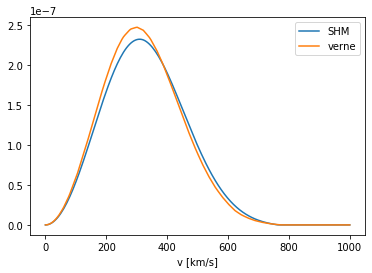

In [10]:
x = np.linspace(0,1000,200) * nu.km / nu.s
# y2 = wr.observed_speed_dist(x, 0)
# plt.plot(x/(nu.km / nu.s),y2)
# plt.axvline(310)
plt.xlabel("v [km/s]")
# plt.ylabel("$f (v)$")
use_SHM = dddm.SHM()
plt.plot(x/(nu.km / nu.s), use_SHM.velocity_dist(x,0), label = 'SHM')
test = dddm.VerneSHM(location="SUF")
# test.velocity_dist(100*nu.km/nu.s,0)
y2 = test.velocity_dist(x, 0)
plt.plot(x/(nu.km / nu.s), y2, label = 'verne')
plt.legend()

In [11]:
!ls ../../verne/results/veldists/f_params_SUF_230_544_0.30_-35.0_0.00_avg.csv

../../verne/results/veldists/f_params_SUF_230_544_0.30_-35.0_0.00_avg.csv


In [12]:
test = pd.DataFrame()
test['a'] = np.linspace(1,2,10)
test['aa'] = np.linspace(1,2,10)
# extra = {'a': np.inf, 
#          'aa':0}
extra = [-1000, 0]
test.loc[len(test)] = extra
extra.reverse
test.loc[len(test)+1] = [1e4,0]
test.sort_values(by=['a'])

,a,aa
10,-1000.000000,0.000000
0,1.000000,1.000000
1,1.111111,1.111111
2,1.222222,1.222222
3,1.333333,1.333333
4,1.444444,1.444444
5,1.555556,1.555556
6,1.666667,1.666667
7,1.777778,1.777778
8,1.888889,1.888889


In [13]:
from scipy.interpolate import interp1d

In [14]:
test2 = interp1d(test['a'], test['aa'])

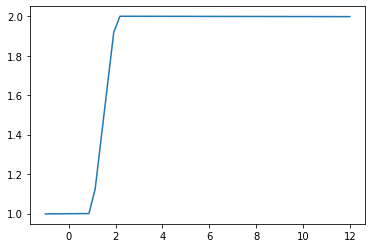

In [15]:
x = np.linspace(-1,12)
plt.plot(x, test2(x))

In [16]:
10000* (nu.km /nu.s)

125504195.10727566

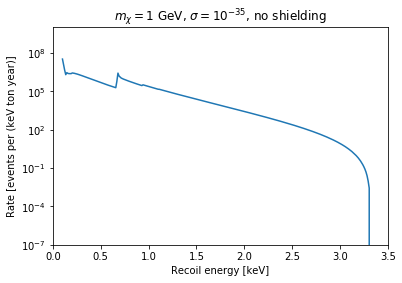

In [34]:
energies = np.linspace(0.1, 3.5, 300)

# dr/dr
dr = ((nu.keV * (1000 * nu.kg) * nu.year) * 
    wr.rate_migdal(energies * nu.keV, 
                    mw=1 * nu.GeV/nu.c0**2, 
                    sigma_nucleon=1e-35 * nu.cm**2))

plt.plot(energies, dr, label="WIMPrates SHM")

plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")

plt.xlim(0, energies.max())
plt.yscale("log")

plt.ylim(1e-7,1e10)
plt.title("$m_\chi = 1$ GeV, $\sigma=10^{-35}$, no shielding")
plt.savefig("migdal_spec_2.png", dpi=300)

## Detector smearing

# Inference #
Below we setup the inference

## Distribution of the DM ##
First we need to make a DM-rate spectrum

In [18]:
use_SHM = dddm.SHM()


In [19]:
test = dddm.VerneSHM()
test.velocity_dist(100*nu.km/nu.s,0)


array(6.69867759e-08)

In [20]:
3404985278.1905413/(nu.km/nu.s)

271304.4990472314

In [21]:
def get_gal_spec(det):
    mw, sig = 1, 1e-35
    experiment = dddm.experiment[det]
    use_verne = dddm.VerneSHM(log_mass = np.log10(mw), 
                              log_cross_section = np.log10(sig),
                              location = experiment['location'])
    spec_class = dddm.GenSpectrum(mw, sig, use_verne, experiment)
#     spec_class.E_max = 1
#     spec_class.mw = 50
    spec_class.n_bins = 20
    return spec_class.get_data(poisson = False)

generating spectrum, this can take a minute. Execute:
python "../../verne/"/src/CalcVelDist.py -m_x 1.0 -sigma_p 1e-35 -loc SUF -path "../../verne//src/" -v_0 230 -v_esc 544 -save_as "../../verne/results/veldists/f_params_SUF_230_544_0.30_-35.0_0.00_avg.csv"


/home/joran/.conda/envs/DD_DM/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


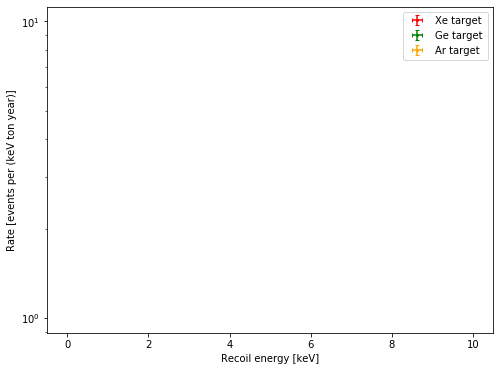

In [31]:
# plot_spectrum(xe_galact, label = 'un-smeared', linestyle = '--')
fig,ax=plt.subplots(figsize = (8,6))
dddm.plot_spectrum(get_gal_spec('Xe_migd'), 'red', label = 'Xe target ', plot_error = False)
dddm.plot_spectrum(get_gal_spec('Ge_migd'), 'green', label = 'Ge target', plot_error = False)
dddm.plot_spectrum(get_gal_spec('Ar_migd'), 'orange', label = 'Ar target', plot_error = False)
plt.yscale("log")
plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.legend()

In [23]:
def get_det_spec(det, mw =50):
    spec_class = dddm.DetectorSpectrum(1, 1e-35, use_SHM, dddm.experiment[det])
#     spec_class.E_max = 200
#     spec_class.mw = mw
    spec_class.n_bins = 20
    return spec_class.get_data(poisson = False)

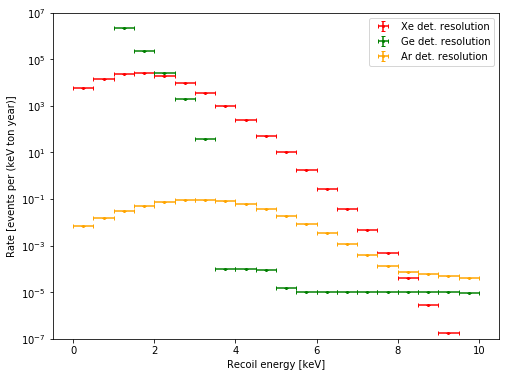

In [24]:
# plot_spectrum(xe_galact, label = 'un-smeared', linestyle = '--')
# %%time
fig,ax=plt.subplots(figsize = (8,6))
dddm.plot_spectrum(get_det_spec('Xe_migd'), 'red', label = 'Xe det. resolution', plot_error = False)
dddm.plot_spectrum(get_det_spec('Ge_migd'), 'green', label = 'Ge det. resolution', plot_error = False)
dddm.plot_spectrum(get_det_spec('Ar_migd'), 'orange', label = 'Ar det. resolution', plot_error = False)
plt.yscale("log")
plt.ylim(1e-7,1e7)
plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.legend()

# Likelihood profiling

In [25]:
# dddm.plt_ll_sigma_spec()

In [26]:
# dddm.plt_ll_sigma_det()

In [27]:
# dddm.plt_ll_mass_spec()
# plt.ylim(-1000,0)

In [28]:
# dddm.plt_ll_mass_det()
# plt.ylim(-1000,0)

# Nested sampling

In [29]:
fit_class = dddm.MCMCStatModel('Xe_migd')
# fit_class.tol = 0.8
fit_class.nwalkers = 5
fit_class.nsteps = 10
# fit_class.nlive = 5
fit_class.set_prior('migdal')
fit_class.set_benchmark(mw = 1, sigma = -35)
print(f"Fitting for parameters:\n{fit_class.fit_parameters}")

StatModel::	initialized for Xe_migd detector. See print(stat_model) for default settings
StatModel::	taking log10 of mass of 1
StatModel::	re-evaluate benchmark
Fitting for parameters:
['log_mass', 'log_cross_section']


In [30]:
fit_class.run_emcee()

/home/joran/.conda/envs/DD_DM/lib/python3.7/site-packages/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
/mnt/c/Users/Joran/Google Drive/PhD-master/ubuntu-storage/windows-anaconda/DD_DM_targets/DirectDmTargets/statistics.py:339: RuntimeWarning: invalid value encountered in log
  return np.log(nr) * nb - loggamma(nb + 1) - nr
Traceback (most recent call last):
  File "/home/joran/.conda/envs/DD_DM/lib/python3.7/site-packages/emcee/ensemble.py", line 546, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/mnt/c/Users/Joran/Google Drive/PhD-master/ubuntu-storage/windows-anaconda/DD_DM_targets/DirectDmTargets/statistics.py", line 220, in log_probability
    ll = log_likelihood(self.benchmark_values, evaluated_rate)
  File "/mnt/c/Users/Joran/Google Drive/PhD-master/ubuntu-storage/windows-anaconda/DD_DM_targets/DirectDmTargets/statistics.py", line 361, i

emcee: Exception while calling your likelihood function:
  params: [  0.         -35.17833621]
  args: [['log_mass', 'log_cross_section']]
  kwargs: {}
  exception:
MCMC did not finish due to a ValueError. Was running with
pos=(5, 2) nsteps = 10, walkers = 5, ndim = 2 for fit parameters ['log_mass', 'log_cross_section']


ValueError: Returned NaN in bin 0. Below follows data dump.
log_likelihood: nan
i = 0, Nb, Nr = -2.6e+25 -1.7e+25 


In [ ]:
fit_class.show_walkers()

In [ ]:
import os

In [ ]:
os.system("cd")

In [ ]:
fit_class.run_nestle()
fit_class.get_summary()

In [ ]:
fit_class.show_corner()

In [ ]:
assert False

In [ ]:
fit_unconstrained = dddm.NestleStatModel('Xe')
fit_unconstrained.tol = 0.8
fit_unconstrained.nlive = 2000
fit_unconstrained.set_fit_parameters(fit_unconstrained.known_parameters)
print(f"Fitting for parameters:\n{fit_unconstrained.fit_parameters}")

In [ ]:
fit_unconstrained.run_nestle()
fit_unconstrained.get_summary()

In [ ]:
fit_unconstrained.show_corner()

In [ ]:
print(1)